## TEST:
Here we investigated whether expectation value of our VQE states on the total magnetization operator:
$$\left<\psi|\hat{M}|\psi\right>\qquad \text{where} \qquad \hat{M} = \frac{1}{N}\sum_{i=1}^N \sigma_x^i$$

Can give us any useful information for a classification without the use of a QCNN.

In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool
import sys
import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn


In [2]:
# Load data:

# Load data and separate in training and test set
data_noisy001 = joblib.load('../vqe_states_job/vqe_params_0.001noise.job')

train_index_noisy001 = np.sort(np.random.choice(np.arange(len(data_noisy001)), size=int(0.8*len(data_noisy001)), replace=False ))

X_train_noisy001, Y_train_noisy001 = [], []
X_test_noisy001, Y_test_noisy001   = [], []

for i in range(len(data_noisy001)): 
    if i in train_index_noisy001:
        X_train_noisy001.append(data_noisy001[i][0])
        Y_train_noisy001.append(data_noisy001[i][1])
    else:
        X_test_noisy001.append(data_noisy001[i][0])
        Y_test_noisy001.append(data_noisy001[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.001):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy001)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy001)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy001)[0]))

# Load data and separate in training and test set
data_noisy005 = joblib.load('../vqe_states_job/vqe_params_0.005noise.job')

train_index_noisy005 = np.sort(np.random.choice(np.arange(len(data_noisy005)), size=int(0.8*len(data_noisy005)), replace=False ))

X_train_noisy005, Y_train_noisy005 = [], []
X_test_noisy005, Y_test_noisy005   = [], []

for i in range(len(data_noisy005)): 
    if i in train_index_noisy005:
        X_train_noisy005.append(data_noisy005[i][0])
        Y_train_noisy005.append(data_noisy005[i][1])
    else:
        X_test_noisy005.append(data_noisy005[i][0])
        Y_test_noisy005.append(data_noisy005[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('NOISY DATA (p noise = 0.005):')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data_noisy005)))
print('Size of Training Set: {0}'.format(np.shape(X_train_noisy005)[0]))
print('Size of Test Set    : {0}\n'.format(np.shape(X_test_noisy005)[0]))


# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/vqe_params_0noise.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

NOISY DATA (p noise = 0.001):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

NOISY DATA (p noise = 0.005):
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [3]:
N = 4
J = 1

In [4]:
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [5]:
@qml.qnode(dev_vqe_mixed)
def magnetization(vqe_params, N, shift_invariance, p_noise = 0, p_noise_ent = 0):
    '''
    Append to the VQE circuit the computation of the expectation values of M
    |0>^N -> VQE CIRCUIT(params) -> psi(params) -> <psi|M|psi>
    '''
    
    # VQE Circuit:
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # Create the M operator
    # Interaction of spins with magnetic field
    M = qml.PauliZ(0)
    for i in range(1,N):
        M += qml.PauliZ(i)
    M = (1/N) * M
    
    # return <psi|M|psi>
    return qml.expval(M)

@qml.qnode(dev_vqe_mixed)
def energy(vqe_params, N, shift_invariance, mu, J, p_noise = 0, p_noise_ent = 0):
    '''
    This circuit outputs instead the expectation value of the Hamiltonian operator
    (Energy)
    '''
    
    # VQE Circuit:
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(vqe.qml_build_H(N, mu, J))

In [6]:
# Prepare M operator
M = qml.PauliZ(0)
for i in range(1,N):
    M += qml.PauliZ(i)
M = (1/N) * M

mags = []
energies = []

# Get analitically the true energies and the true magnetizations
for mu in np.linspace(0,2*J,100):
    # Prepare H operator
    H = np.real( qml.matrix(vqe.qml_build_H(N,float(mu),J) ) )
    
    # Compute the eigenvalue and eigenvector of the Hamiltonian
    eigval, eigvec = np.linalg.eig(H)
    
    # Get the eigenvector associated to the lowest eigenvalue of H
    gstate = eigvec[:,np.argmin(eigval)]
    
    # Being |GS> the ground state of the system:
    # <GS|M|GS>
    mags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    # <GS|H|GS>
    energies.append( np.transpose(gstate) @ H @ gstate )

In [7]:
# Now we get the same results with the ground states obtained using the VQE algorithm
# 1. Noisyless circuit
# 2. Circuit with 0.001 noise
# 3. Circuit with 0.005 noise

mags_circuit_0noise = []
enes_circuit_0noise = []
for i, state in enumerate(data):
    # Compute magnetization for each state (mu)
    mags_circuit_0noise.append(magnetization(state[0], N, 0) )
    # Compute energy for each state (mu)
    enes_circuit_0noise.append(energy(state[0], N, 0, float(2*i/J), J) )
    
mags_circuit_001noise = []
enes_circuit_001noise = []
for i, state in enumerate(data_noisy001):
    # Compute magnetization for each state (mu)
    mags_circuit_001noise.append(magnetization(state[0], N, 0) )
    # Compute energy for each state (mu)
    enes_circuit_001noise.append(energy(state[0], N, 0, float(2*i/J), J) )
    
mags_circuit_005noise = []
enes_circuit_005noise = []
for i, state in enumerate(data_noisy005):
    # Compute magnetization for each state (mu)
    mags_circuit_005noise.append(magnetization(state[0], N, 0) )
    # Compute energy for each state (mu)
    enes_circuit_005noise.append(energy(state[0], N, 0, float(2*i/J), J) )
    

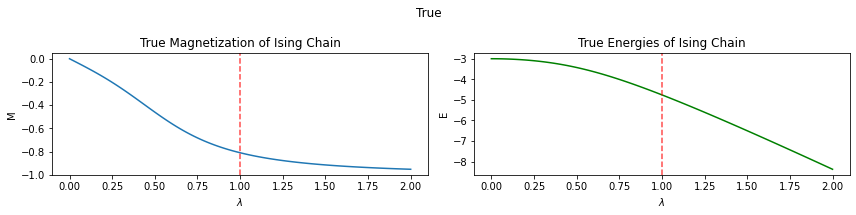

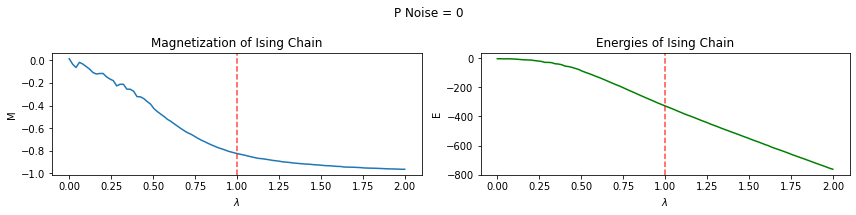

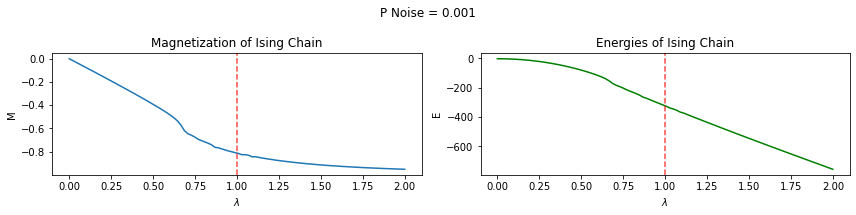

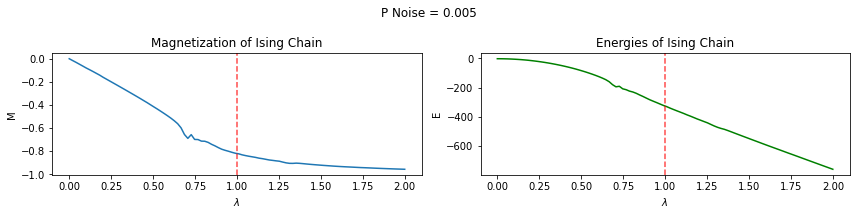

In [8]:
x = np.linspace(0,2*J,100)

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('True')
ax[0].plot(x, np.real(mags) )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('True Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, np.real(energies), color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('True Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0')
ax[0].plot(x, mags_circuit_0noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_0noise, color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0.001')
ax[0].plot(x, mags_circuit_001noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_001noise, color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(12,3))
fig.suptitle('P Noise = 0.005')
ax[0].plot(x, mags_circuit_005noise )
ax[0].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[0].set_title('Magnetization of Ising Chain')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('M')
ax[1].plot(x, enes_circuit_005noise, color ='green')
ax[1].axvline(x=J, color='red', alpha = 0.7, ls = '--')
ax[1].set_title('Energies of Ising Chain')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel('E')
plt.tight_layout()

We now would like to investigate what are the values of total magnetization at the point of phase-transition:

In [9]:
jmags = []

for j in np.linspace(1,5,100):
    # For each j, compute the hamiltonian at the phase-transition
    # mu = j
    H = np.real( qml.matrix(vqe.qml_build_H(N,float(j),float(j) )) )
    
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = np.linalg.eig(H)
    # Get the eigenstate to the lowest eigenvalue
    gstate = eigvec[:,np.argmin(eigval)]
    
    # Compute <GS|H|GS>
    jmags.append(np.real( np.transpose(gstate) @ qml.matrix(M) @ gstate ) )
    

(0.0, -1.0)

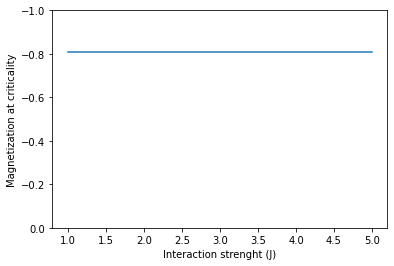

In [10]:
plt.plot(np.linspace(1,5,100), jmags)
plt.xlabel('Interaction strenght (J)')
plt.ylabel('Magnetization at criticality')
plt.ylim(0,-1)

In [11]:
nmags = []
J = 1
for n in range(2,12):
    # For n in range(2,12) and J == 1 we compute the value of magnetization
    # at criticality
    M = qml.PauliZ(0)
    for i in range(1,n):
        M += qml.PauliZ(i)
    M = (1/n) * M
    
    # Compute the hamiltonian
    H = np.real( qml.matrix(vqe.qml_build_H(n,float(J),float(J) )) )
    
    # Compute eigenvalues and eigenvectors
    eigval, eigvec = np.linalg.eig(H)
    # Get the eigenstate to the lowest eigenvalue
    gstate = eigvec[:,np.argmin(eigval)]

    # Compute <GS|H|GS>
    nmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
    

/home/saverio/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Number of spins (N)')

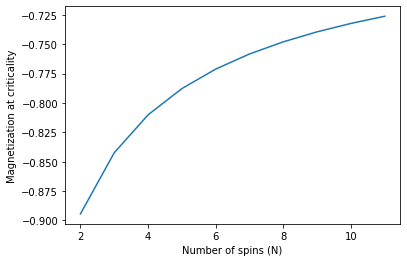

In [12]:
plt.plot(range(2,12),nmags)
plt.ylabel('Magnetization at criticality')
plt.xlabel('Number of spins (N)')

In [13]:
jnmags = []

for j in np.linspace(1,2,5):
    nmags = []
    for n in range(2,10):
        M = qml.PauliZ(0)
        for i in range(1,n):
            M += qml.PauliZ(i)
        M = (1/n) * M
        
        H = np.real( qml.matrix(vqe.qml_build_H(n,float(j),float(j) )) )
        eigval, eigvec = np.linalg.eig(H)
        gstate = eigvec[:,np.argmin(eigval)]
        nmags.append( np.transpose(gstate) @ qml.matrix(M) @ gstate )
        
    jnmags.append(nmags)

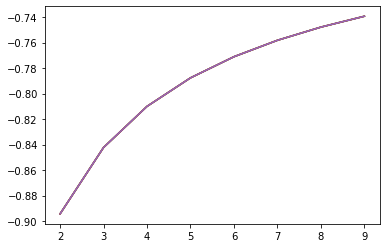

In [14]:
for nmag in jnmags:
    plt.plot(range(2,10), nmag)
plt.show()